<a href="https://colab.research.google.com/github/aslestia/ACS_2025/blob/main/MC_Blackjack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Monte Carlo Learning — Blackjack (21)  
**First-Visit vs Every-Visit, plus MC Control (Exploring Starts & ε-soft)**

Notebook ini menyajikan implementasi **Monte Carlo (MC) Learning** pada lingkungan **Blackjack** dengan dua varian utama:
- **First-Visit MC**: hanya memperbarui nilai untuk kunjungan pertama suatu state dalam sebuah episode.
- **Every-Visit MC**: memperbarui nilai untuk setiap kunjungan state dalam sebuah episode.

Selain itu, notebook juga menyertakan **MC Control** dengan:
- **Exploring Starts (ES)**, dan
- **ε-soft policy improvement**.

Struktur notebook mengikuti pola pembelajaran yang rapi: konsep, implementasi, eksperimen, visualisasi, dan tugas (TODO) bagi mahasiswa.



## 1. Persiapan Lingkungan & Utilitas

Kode di bawah ini mencoba menggunakan **gymnasium** terlebih dahulu. Jika tidak tersedia, akan mencoba **gym** klasik.  
Environment yang digunakan: `Blackjack-v1` (gymnasium) atau `Blackjack-v0` (gym).

> Catatan: Eksekusi notebook ini tidak memerlukan internet. Pastikan salah satu dari `gymnasium` atau `gym` telah terpasang.


In [ ]:

import math
import random
from collections import defaultdict
from typing import Dict, Tuple, List, Callable

# Visualisasi
import numpy as np
import matplotlib.pyplot as plt

# Coba import gymnasium, jika gagal, fallback ke gym
env = None
use_gymnasium = False

try:
    import gymnasium as gym
    env = gym.make("Blackjack-v1", sab=False)  # sab=False => rules klasik OpenAI Gym
    use_gymnasium = True
except Exception as e:
    try:
        import gym
        env = gym.make("Blackjack-v0")
        use_gymnasium = False
    except Exception as e2:
        raise ImportError("Tidak menemukan gymnasium maupun gym. Silakan install salah satunya, mis. `pip install gymnasium[classic-control]` atau `pip install gym[other]`.")

print("Backend:", "gymnasium" if use_gymnasium else "gym")
print("Observation space:", env.observation_space)
print("Action space:", env.action_space)


Backend: gymnasium
Observation space: Tuple(Discrete(32), Discrete(11), Discrete(2))
Action space: Discrete(2)



## 2. Representasi State & Kebijakan (Policy)

State pada Blackjack direpresentasikan sebagai tuple: `(player_sum, dealer_showing, usable_ace)`.
Aksi: `0 = stick`, `1 = hit`.

Kita sediakan contoh **kebijakan baseline** yang sederhana: *stick* jika `player_sum >= 20`, selain itu *hit*.


In [ ]:

State = Tuple[int, int, bool]
Action = int  # 0: stick, 1: hit

def baseline_policy(state: State) -> Action:
    player_sum, dealer_show, usable_ace = state
    return 0 if player_sum >= 20 else 1  # stick if >=20, else hit

def random_policy(state: State) -> Action:
    return 0 if random.random() < 0.5 else 1

# Untuk policy table (state->action), gunakan default ke baseline jika belum ada
def make_greedy_policy_from_q(Q: Dict[Tuple[State, Action], float]) -> Callable[[State], Action]:
    def policy(state: State) -> Action:
        # Ambil aksi dengan Q-value maksimum
        q0 = Q.get((state, 0), 0.0)
        q1 = Q.get((state, 1), 0.0)
        return 0 if q0 >= q1 else 1
    return policy

def epsilon_greedy_policy_from_q(Q: Dict[Tuple[State, Action], float], eps: float) -> Callable[[State], Action]:
    greedy = make_greedy_policy_from_q(Q)
    def policy(state: State) -> Action:
        if random.random() < eps:
            return random_policy(state)
        else:
            return greedy(state)
    return policy



## 3. Membentuk Episode

Fungsi pembentuk episode di bawah ini akan menjalankan environment hingga terminal, dengan menggunakan policy tertentu.


In [ ]:

def generate_episode(env, policy: Callable[[State], Action]) -> List[Tuple[State, Action, float]]:
    if use_gymnasium:
        state, _ = env.reset()
    else:
        state = env.reset()
    episode = []
    done = False
    while not done:
        action = policy(state)
        if use_gymnasium:
            next_state, reward, terminated, truncated, _info = env.step(action)
            done = terminated or truncated
        else:
            next_state, reward, done, _info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
    return episode



## 4. MC Prediction: First-Visit vs Every-Visit

- **First-Visit MC**: Untuk tiap episode, hanya kunjungan **pertama** suatu state yang dihitung untuk memperbarui nilai.
- **Every-Visit MC**: Setiap kali state muncul dalam sebuah episode, semuanya digunakan untuk memperbarui nilai.


In [ ]:

def mc_prediction(
    env,
    policy: Callable[[State], Action],
    num_episodes: int = 50000,
    gamma: float = 1.0,
    first_visit: bool = True,
) -> Dict[State, float]:
    V = defaultdict(float)
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)

    for _ in range(num_episodes):
        episode = generate_episode(env, policy)
        # List of (state, action, reward); kita ubah ke (state, reward) untuk nilai state
        states_in_episode = [step[0] for step in episode]
        rewards = [step[2] for step in episode]

        # Hitung return dari setiap time step t
        G = 0.0
        returns = [0.0]*len(episode)
        for t in reversed(range(len(episode))):
            G = gamma * G + rewards[t]
            returns[t] = G

        visited = set()
        for t, state in enumerate(states_in_episode):
            if first_visit:
                if state in visited:
                    continue
                visited.add(state)
            # Update rata-rata kumulatif
            returns_sum[state] += returns[t]
            returns_count[state] += 1.0
            V[state] = returns_sum[state] / returns_count[state]
    return V



## 5. MC Control

Dua pendekatan yang disertakan:

1. **MC Control dengan Exploring Starts (ES)**  
   Memaksa setiap state–action berpeluang untuk dieksplor di awal episode.

2. **MC Control dengan ε-soft policy**  
   Menggunakan **ε-greedy** terhadap Q untuk menjamin eksplorasi berkelanjutan.


In [ ]:

def mc_control_exploring_starts(
    env,
    num_episodes: int = 500000,
    gamma: float = 1.0,
) -> Tuple[Dict[Tuple[State, Action], float], Callable[[State], Action]]:
    Q = defaultdict(float)
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    actions = [0, 1]

    for _ in range(num_episodes):
        # Exploring starts: mulai dari state acak (jika memungkinkan) dan aksi acak
        # Tidak semua implementasi gym menyediakan reset ke state spesifik.
        # Sebagai pendekatan praktis, mulai episode normal lalu pilih aksi pertama secara acak.
        if use_gymnasium:
            state, _ = env.reset()
        else:
            state = env.reset()
        first_action = random.choice(actions)

        episode = []
        done = False

        # Langkah pertama dengan aksi acak (exploring start)
        if use_gymnasium:
            next_state, reward, terminated, truncated, _info = env.step(first_action)
            done = terminated or truncated
        else:
            next_state, reward, done, _info = env.step(first_action)
        episode.append((state, first_action, reward))
        state = next_state

        # Lanjutkan dengan policy greedy terhadap Q
        def greedy_act(s: State) -> Action:
            q0 = Q.get((s, 0), 0.0)
            q1 = Q.get((s, 1), 0.0)
            return 0 if q0 >= q1 else 1

        while not done:
            a = greedy_act(state)
            if use_gymnasium:
                next_state, reward, terminated, truncated, _info = env.step(a)
                done = terminated or truncated
            else:
                next_state, reward, done, _info = env.step(a)
            episode.append((state, a, reward))
            state = next_state

        # Hitung return dan update setiap pasangan (s,a) saat pertama kali muncul (First-Visit untuk control)
        G = 0.0
        sa_visited = set()
        for t in reversed(range(len(episode))):
            s, a, r = episode[t]
            G = gamma * G + r
            if (s, a) not in sa_visited:
                sa_visited.add((s, a))
                returns_sum[(s, a)] += G
                returns_count[(s, a)] += 1.0
                Q[(s, a)] = returns_sum[(s, a)] / returns_count[(s, a)]

    policy = make_greedy_policy_from_q(Q)
    return Q, policy


def mc_control_epsilon_soft(
    env,
    num_episodes: int = 500000,
    gamma: float = 1.0,
    epsilon: float = 0.1
) -> Tuple[Dict[Tuple[State, Action], float], Callable[[State], Action]]:
    Q = defaultdict(float)
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)

    policy = epsilon_greedy_policy_from_q(Q, epsilon)

    for _ in range(num_episodes):
        episode = generate_episode(env, policy)

        # Hitung return
        G = 0.0
        sa_visited = set()
        for t in reversed(range(len(episode))):
            s, a, r = episode[t]
            G = gamma * G + r
            if (s, a) not in sa_visited:
                sa_visited.add((s, a))
                returns_sum[(s, a)] += G
                returns_count[(s, a)] += 1.0
                Q[(s, a)] = returns_sum[(s, a)] / returns_count[(s, a)]
        # policy sudah ε-greedy terhadap Q; akan berevolusi seiring Q berubah
    final_policy = make_greedy_policy_from_q(Q)
    return Q, final_policy



## 6. Ekstraksi Nilai & Visualisasi

Kita akan mengekstrak **state-value function** dari **Q** (dengan `V(s) = max_a Q(s,a)`) atau langsung dari hasil prediksi `V`.  
Visualisasi berupa **heatmap** untuk dua kondisi: `usable_ace = True` dan `usable_ace = False`.

> Warna default dari matplotlib akan digunakan (tanpa styling khusus).


In [ ]:

def value_from_q(Q: Dict[Tuple[State, Action], float]) -> Dict[State, float]:
    V = defaultdict(float)
    for (s, a), q in Q.items():
        V[s] = max(V[s], q)
    return V

def extract_grid(V: Dict[State, float], usable_ace: bool) -> np.ndarray:
    # Player sum: 12..21, Dealer showing: 1..10
    grid = np.zeros((10, 10))
    for player_sum in range(12, 22):
        for dealer in range(1, 11):
            state = (player_sum, dealer, usable_ace)
            grid[player_sum - 12, dealer - 1] = V.get(state, 0.0)
    return grid

def plot_value_function(V: Dict[State, float], title_prefix: str = "V"):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    grid_ua = extract_grid(V, True)
    grid_no_ua = extract_grid(V, False)

    ax = axes[0]
    im = ax.imshow(grid_ua, origin="lower", extent=[1,10,12,21], aspect="auto")
    ax.set_title(f"{title_prefix} (Usable Ace = True)")
    ax.set_xlabel("Dealer Showing")
    ax.set_ylabel("Player Sum")
    fig.colorbar(im, ax=ax)

    ax = axes[1]
    im2 = ax.imshow(grid_no_ua, origin="lower", extent=[1,10,12,21], aspect="auto")
    ax.set_title(f"{title_prefix} (Usable Ace = False)")
    ax.set_xlabel("Dealer Showing")
    ax.set_ylabel("Player Sum")
    fig.colorbar(im2, ax=ax)

    plt.show()



## 7. Eksperimen Cepat — MC Prediction

Di bawah ini contoh perbandingan **First-Visit** vs **Every-Visit** untuk kebijakan baseline.  
Jumlah episode dapat disesuaikan sesuai kebutuhan (trade-off waktu vs akurasi).


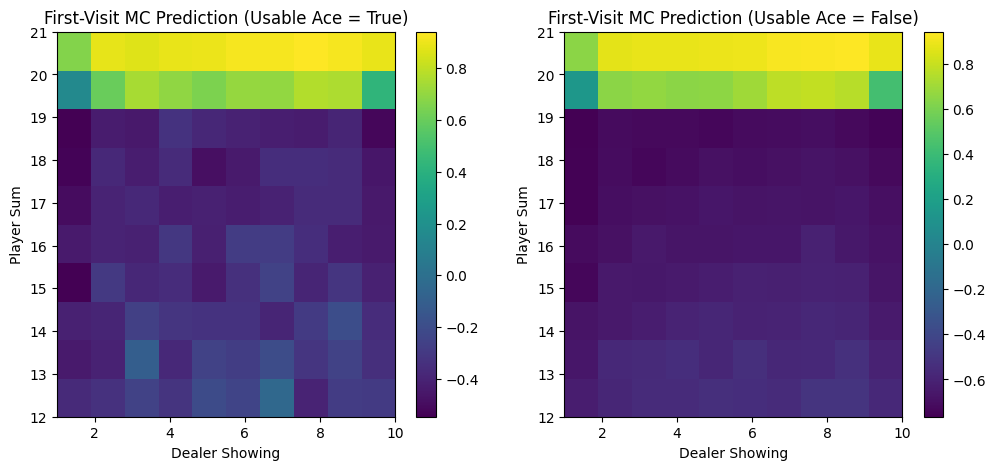

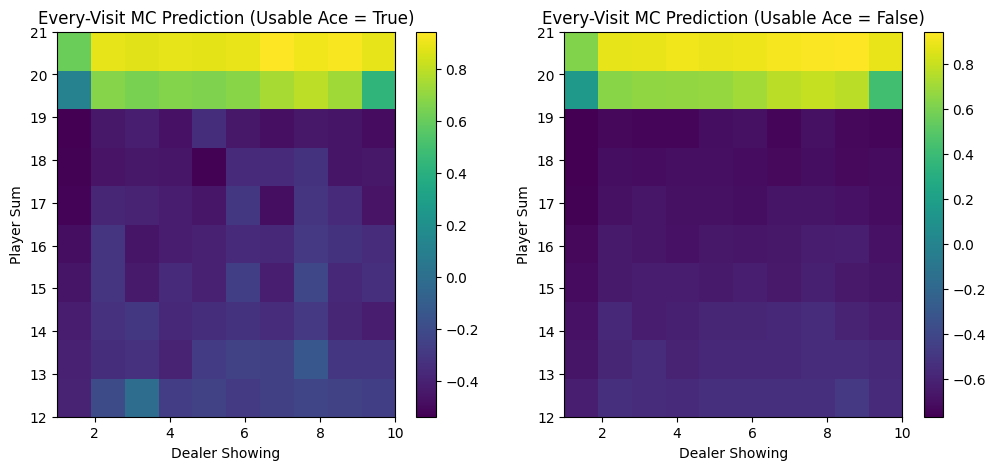

In [ ]:

# Parameter eksperimen
N_EPISODES = 200000  # naikkan/kurangi sesuai kebutuhan
GAMMA = 1.0

# First-Visit
V_first = mc_prediction(env, baseline_policy, num_episodes=N_EPISODES, gamma=GAMMA, first_visit=True)
plot_value_function(V_first, title_prefix="First-Visit MC Prediction")

# Every-Visit
V_every = mc_prediction(env, baseline_policy, num_episodes=N_EPISODES, gamma=GAMMA, first_visit=False)
plot_value_function(V_every, title_prefix="Every-Visit MC Prediction")



## 8. Eksperimen — MC Control

Menjalankan **MC Control dengan Exploring Starts** dan **ε-soft** untuk memperoleh **kebijakan mendekati optimal**.


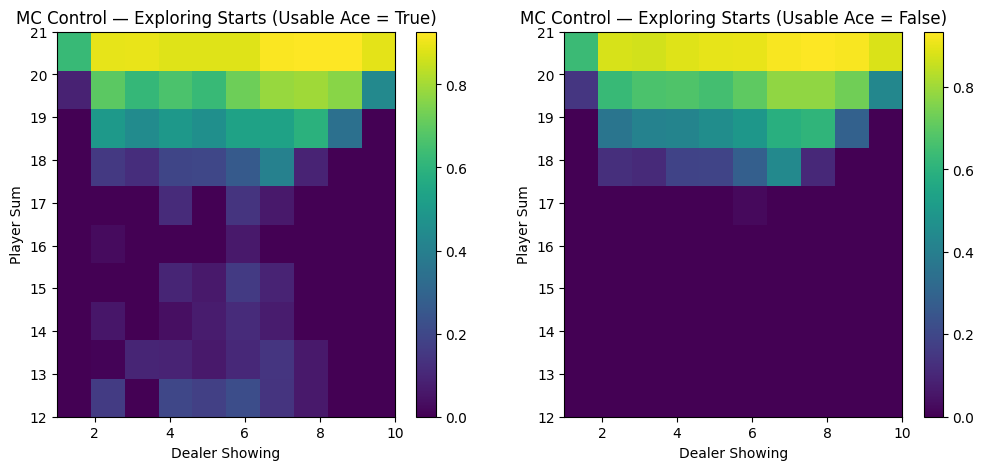

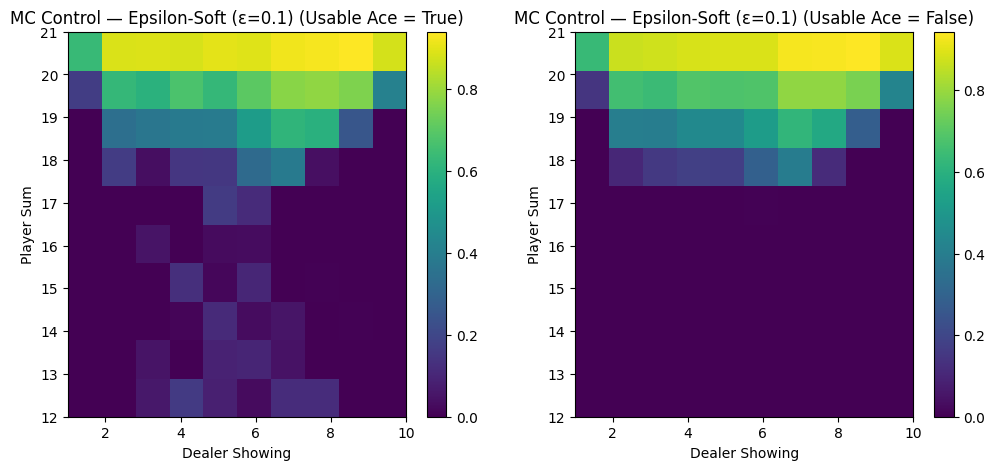

In [ ]:

# MC Control — Exploring Starts
Q_es, policy_es = mc_control_exploring_starts(env, num_episodes=400000, gamma=1.0)
V_es = value_from_q(Q_es)
plot_value_function(V_es, title_prefix="MC Control — Exploring Starts")

# MC Control — ε-soft
Q_eps, policy_eps = mc_control_epsilon_soft(env, num_episodes=400000, gamma=1.0, epsilon=0.1)
V_eps = value_from_q(Q_eps)
plot_value_function(V_eps, title_prefix="MC Control — Epsilon-Soft (ε=0.1)")



## 9. Evaluasi Kebijakan (Greedy Eval)

Kita evaluasi kebijakan hasil MC Control dengan menjalankan sejumlah episode dan menghitung **rata-rata return**.


In [ ]:

def evaluate_policy(env, policy: Callable[[State], Action], num_episodes: int = 100000) -> float:
    total_return = 0.0
    for _ in range(num_episodes):
        episode = generate_episode(env, policy)
        G = sum([step[2] for step in episode])  # gamma=1
        total_return += G
    return total_return / num_episodes

avg_return_es = evaluate_policy(env, policy_es, num_episodes=100000)
avg_return_eps = evaluate_policy(env, policy_eps, num_episodes=100000)

print("Greedy eval — MC Control (Exploring Starts):", avg_return_es)
print("Greedy eval — MC Control (ε-soft):", avg_return_eps)


Greedy eval — MC Control (Exploring Starts): -0.04608
Greedy eval — MC Control (ε-soft): -0.0558



## 10. **Latihan (TODO)**

1. **Parameter Study:** Ubah jumlah episode (`N_EPISODES`) untuk MC Prediction. Catat bagaimana estimasi nilai berubah, terutama di area `player_sum` tinggi vs rendah.  
2. **Perbandingan First-Visit vs Every-Visit:** Untuk beberapa nilai episode (mis. 50k, 100k, 200k), bandingkan heatmap dan jelaskan perbedaannya.  
3. **Policy Baseline Alternatif:** Modifikasi baseline policy (mis. stick jika `player_sum >= 19`) dan ulangi MC Prediction. Bagaimana dampaknya pada `V`?  
4. **MC Control ε-soft — Sensitivitas ε:** Coba `ε` pada {0.01, 0.05, 0.1, 0.2}. Analisis trade-off eksplorasi vs konvergensi.  
5. **Bandingkan Dua Kebijakan Hasil Control:** Visualisasikan perbedaan `V_es` vs `V_eps` dan evaluasi rata-rata return-nya.  


## 11. Lampiran — Tips & Troubleshooting

- Jika environment `Blackjack-v1` tidak tersedia, gunakan `Blackjack-v0` dari `gym` klasik.
- Untuk mempercepat komputasi, kurangi jumlah episode terlebih dahulu lalu tingkatkan secara bertahap.
- Pastikan **matplotlib** tersedia untuk visualisasi heatmap.
- Jika ingin menyimpan `V` atau `Q`, gunakan `pickle` atau `numpy.save` sesuai kebutuhan Anda.
